# Sea ice timeseries for ACCESS-OM3

This notebook 

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
esm_file = '/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

ESM datastore path:  /g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json
Plot folder path:  /g/data/lo70/hs5546/access-om3-paper-figs/


In [2]:
import intake
from xarray import DataTree, map_over_datasets

from dask.distributed import Client

import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines

In [3]:
IAF = esm_file.find('iaf') > 0

In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39823 instead
  warnings.warn(


/proxy/39823/status


In [5]:
if IAF:
    t_slice = slice('2009','2018') #manually pick some years in both om2 & 3 experiments
else:
    years = np.unique(ds.time.dt.year)[-10:]
    t_slice = slice(str(years[0]),str(years[-1]))
    t_slice

# Data

## Open the intake-esm datastore

In [6]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


In [7]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [8]:
variable = "aice_m"
area_variable = "tarea"

In [9]:
dset = datastore.search(variable=variable, frequency="1mon").to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


In [10]:
tarea = datastore.search(variable=area_variable, frequency="fx", realm="seaIce").to_dask()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


## Observations

In [11]:
sh_obs = xr.open_mfdataset('/g/data/av17/access-nri/OM3/CDR_G02202_V5/NSIDC-G02202-sh/sic_pss25*.nc')

In [12]:
nh_obs = xr.open_mfdataset('/g/data/av17/access-nri/OM3/CDR_G02202_V5/NSIDC-G02202-nh/sic_psn25*.nc')

In [144]:
#!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

--2025-12-01 16:33:41--  ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat
           => ‘pss25area_v3.dat’
128.138.135.20ds.colorado.edu (sidads.colorado.edu)... 
connected. to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... 
Logging in as anonymous ... Logged in!
done.    ==> PWD ... done.
done.  ==> CWD (1) /DATASETS/seaice/polar-stereo/tools ... done.
419648ZE pss25area_v3.dat ... 
done.    ==> RETR pss25area_v3.dat ... done.
Length: 419648 (410K) (unauthoritative)

pss25area_v3.dat    100%[===================>] 409.81K   474KB/s    in 0.9s    

2025-12-01 16:33:45 (474 KB/s) - ‘pss25area_v3.dat’ saved [419648]

--2025-12-01 16:33:45--  ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat
           => ‘psn25area_v3.dat’
connected. to sidads.colorado.edu (sidads.colorado.edu)|128.138.135.20|:21... 
Logging in as anonymous ... Logged in!
done.    ==> PWD ... done.
done.  ==> CWD (1) /DATASETS/seaice/polar-stereo/to

In [51]:
areasNd = np.fromfile("pss25area_v3.dat", dtype=np.int32).reshape(
    sh_obs.cdr_seaice_conc_monthly.isel(time=0).shape
)
areasKmNd_sh = areasNd /1000 #convert to km^2
    
sh_obs["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
sh_obs = sh_obs.set_coords("area")

In [52]:
areasNd = np.fromfile("psn25area_v3.dat", dtype=np.int32).reshape(
    nh_obs.cdr_seaice_conc_monthly.isel(time=0).shape
)
areasKmNd_nh = areasNd /1000 #convert to km^2
    
nh_obs["area"] = xr.DataArray(areasKmNd_nh, dims=["y", "x"])
nh_obs = nh_obs.set_coords("area")

# Calculation

In [15]:
client.close()

In [44]:
sic = dset[variable]
area = tarea[area_variable].load()

antarctic_seaice = (sic * area).sel(nj=slice(0,int(len(dset.nj)/2))).sum(['nj','ni'])
arctic_seaice = (sic * area).sel(nj=slice(int(len(dset.nj)/2), None)).sum(['nj','ni'])

sh_area = antarctic_seaice.compute()
nh_area = arctic_seaice.compute()

In [53]:
sh_sic = sh_obs['cdr_seaice_conc_monthly']
sharea = sh_obs.area.load()

nh_sic = nh_obs['cdr_seaice_conc_monthly']
nharea = nh_obs.area.load()

antarctic_seaice_obs = (sh_sic * sharea).sum(['y','x'])
arctic_seaice_obs = (nh_sic * nharea).sum(['y','x'])

sh_area_obs = antarctic_seaice_obs.compute()
nh_area_obs = arctic_seaice_obs.compute()

In [92]:
nh_area_obs.loc[{"time": "1984-07-01"}] = np.nan
nh_area_obs.loc[{"time": "1988-01-01"}] = np.nan
nh_area_obs.loc[{"time": "1987-12"}] = np.nan

sh_area_obs.loc[{"time": "1988-01-01"}] = np.nan
sh_area_obs.loc[{"time": "1987-12"}] = np.nan

# Plot

In [19]:
font = {'size':13}
tick_font=12

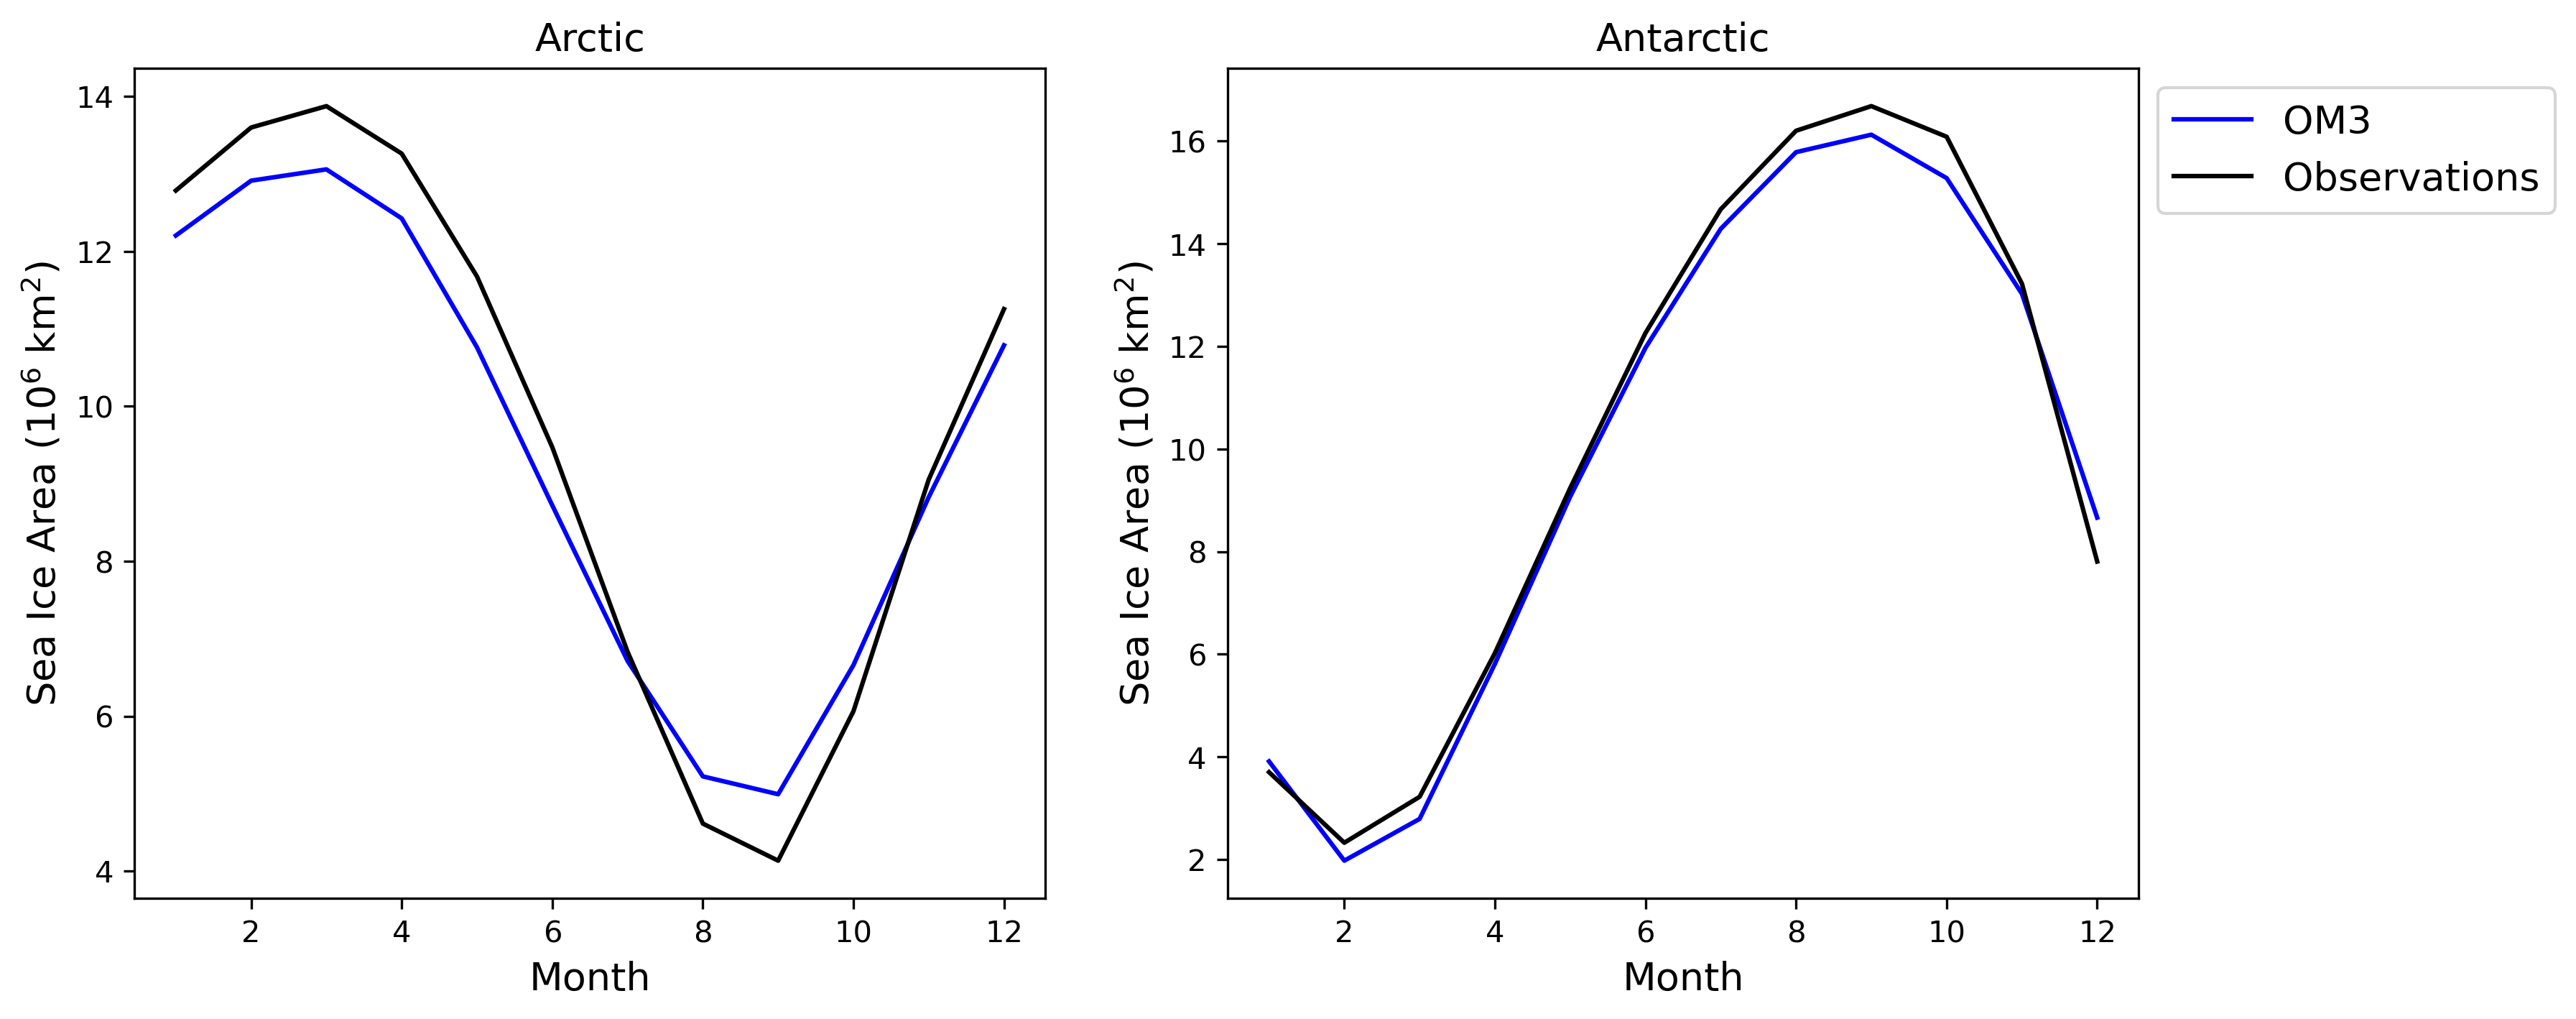

In [97]:
plt.figure(1,(12,5))

plt.subplot(1,2,1)
(nh_area.sel(time=t_slice).groupby('time.month').mean('time') / 1e12).plot(label = 'OM3',c='b')      # convert from m^2 -> 10^6 km^2
(nh_area_obs.sel(time=t_slice).groupby('time.month').mean('time') / 1e6).plot(label = 'Observations',c='k')      # convert from km^2 -> 10^6 km^2

plt.xlabel('Month',font)
plt.ylabel('Sea Ice Area (10$^6$ km$^2$)',font)
plt.title('Arctic',font)

plt.subplot(1,2,2)
(sh_area.sel(time=t_slice).groupby('time.month').mean('time') / 1e12).plot(label = 'OM3',c='b')   # convert from m^2 -> 10^6 km^2
(sh_area_obs.sel(time=t_slice).groupby('time.month').mean('time') / 1e6).plot(label = 'Observations',c='k')   # convert from km^2 -> 10^6 km^2

plt.xlabel('Month',font)
plt.ylabel('Sea Ice Area (10$^6$ km$^2$)',font)
plt.title('Antarctic',font)

plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

# savefigure('ice_area_monthly_climatology')

plt.show()

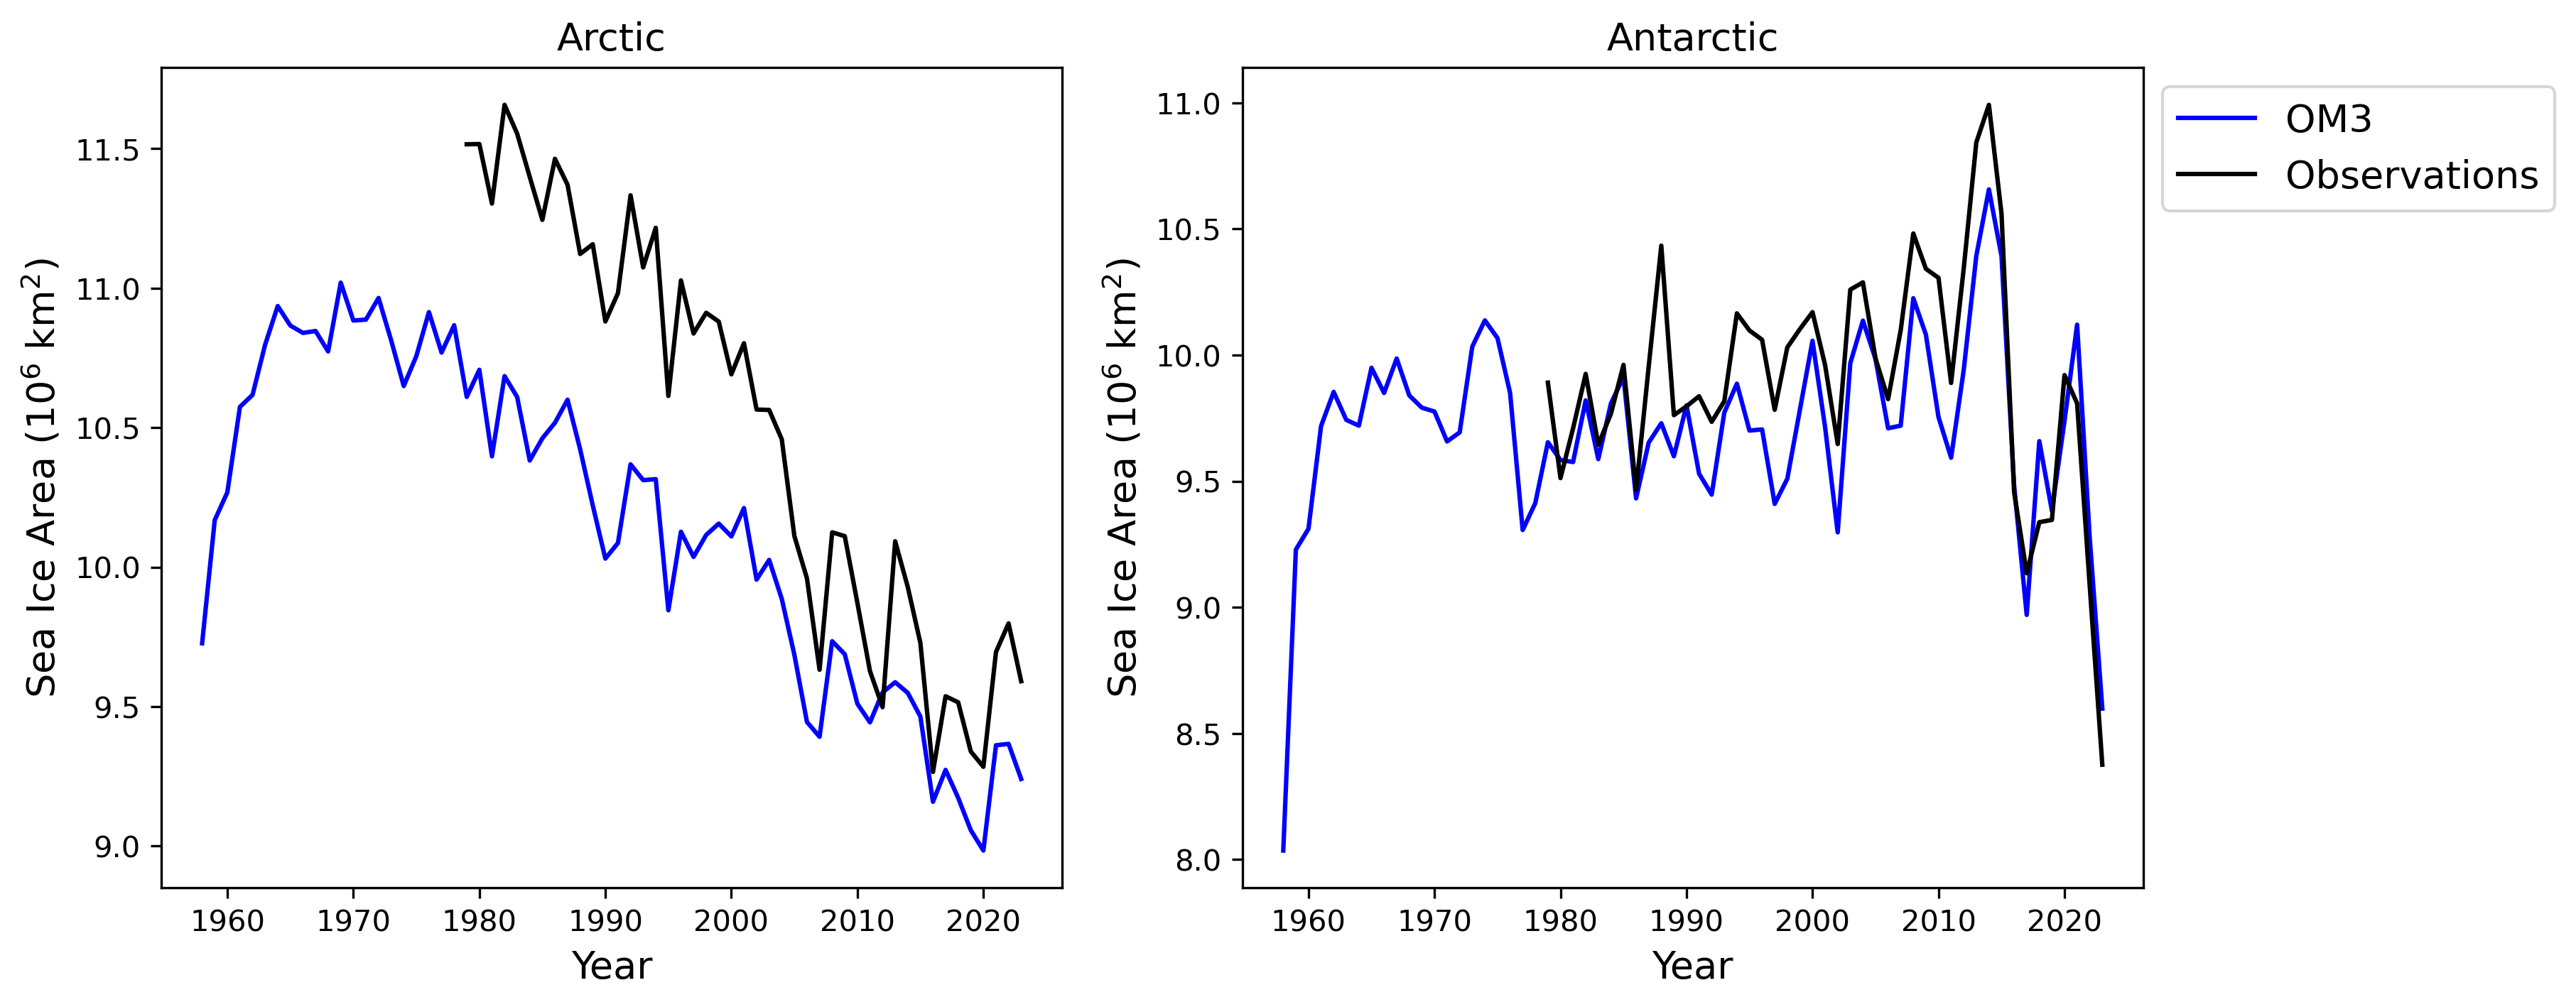

In [98]:
plt.figure(1,(12,5))

plt.subplot(1,2,1)
(nh_area.groupby('time.year').mean('time') / 1e12).plot(label = 'OM3',c='b')      # convert from m^2 -> 10^6 km^2
(nh_area_obs.groupby('time.year').mean('time')[:-1] / 1e6).plot(label = 'Observations',c='k')      # convert from km^2 -> 10^6 km^2

plt.xlabel('Year',font)
plt.ylabel('Sea Ice Area (10$^6$ km$^2$)',font)
plt.title('Arctic',font)

plt.subplot(1,2,2)
(sh_area.groupby('time.year').mean('time') / 1e12).plot(label = 'OM3',c='b')   # convert from m^2 -> 10^6 km^2
(sh_area_obs.groupby('time.year').mean('time')[:-1] / 1e6).plot(label = 'Observations',c='k')   # convert from km^2 -> 10^6 km^2

plt.xlabel('Year',font)
plt.ylabel('Sea Ice Area (10$^6$ km$^2$)',font)
plt.title('Antarctic',font)

plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

# savefigure('ice_area_annual')

plt.show()

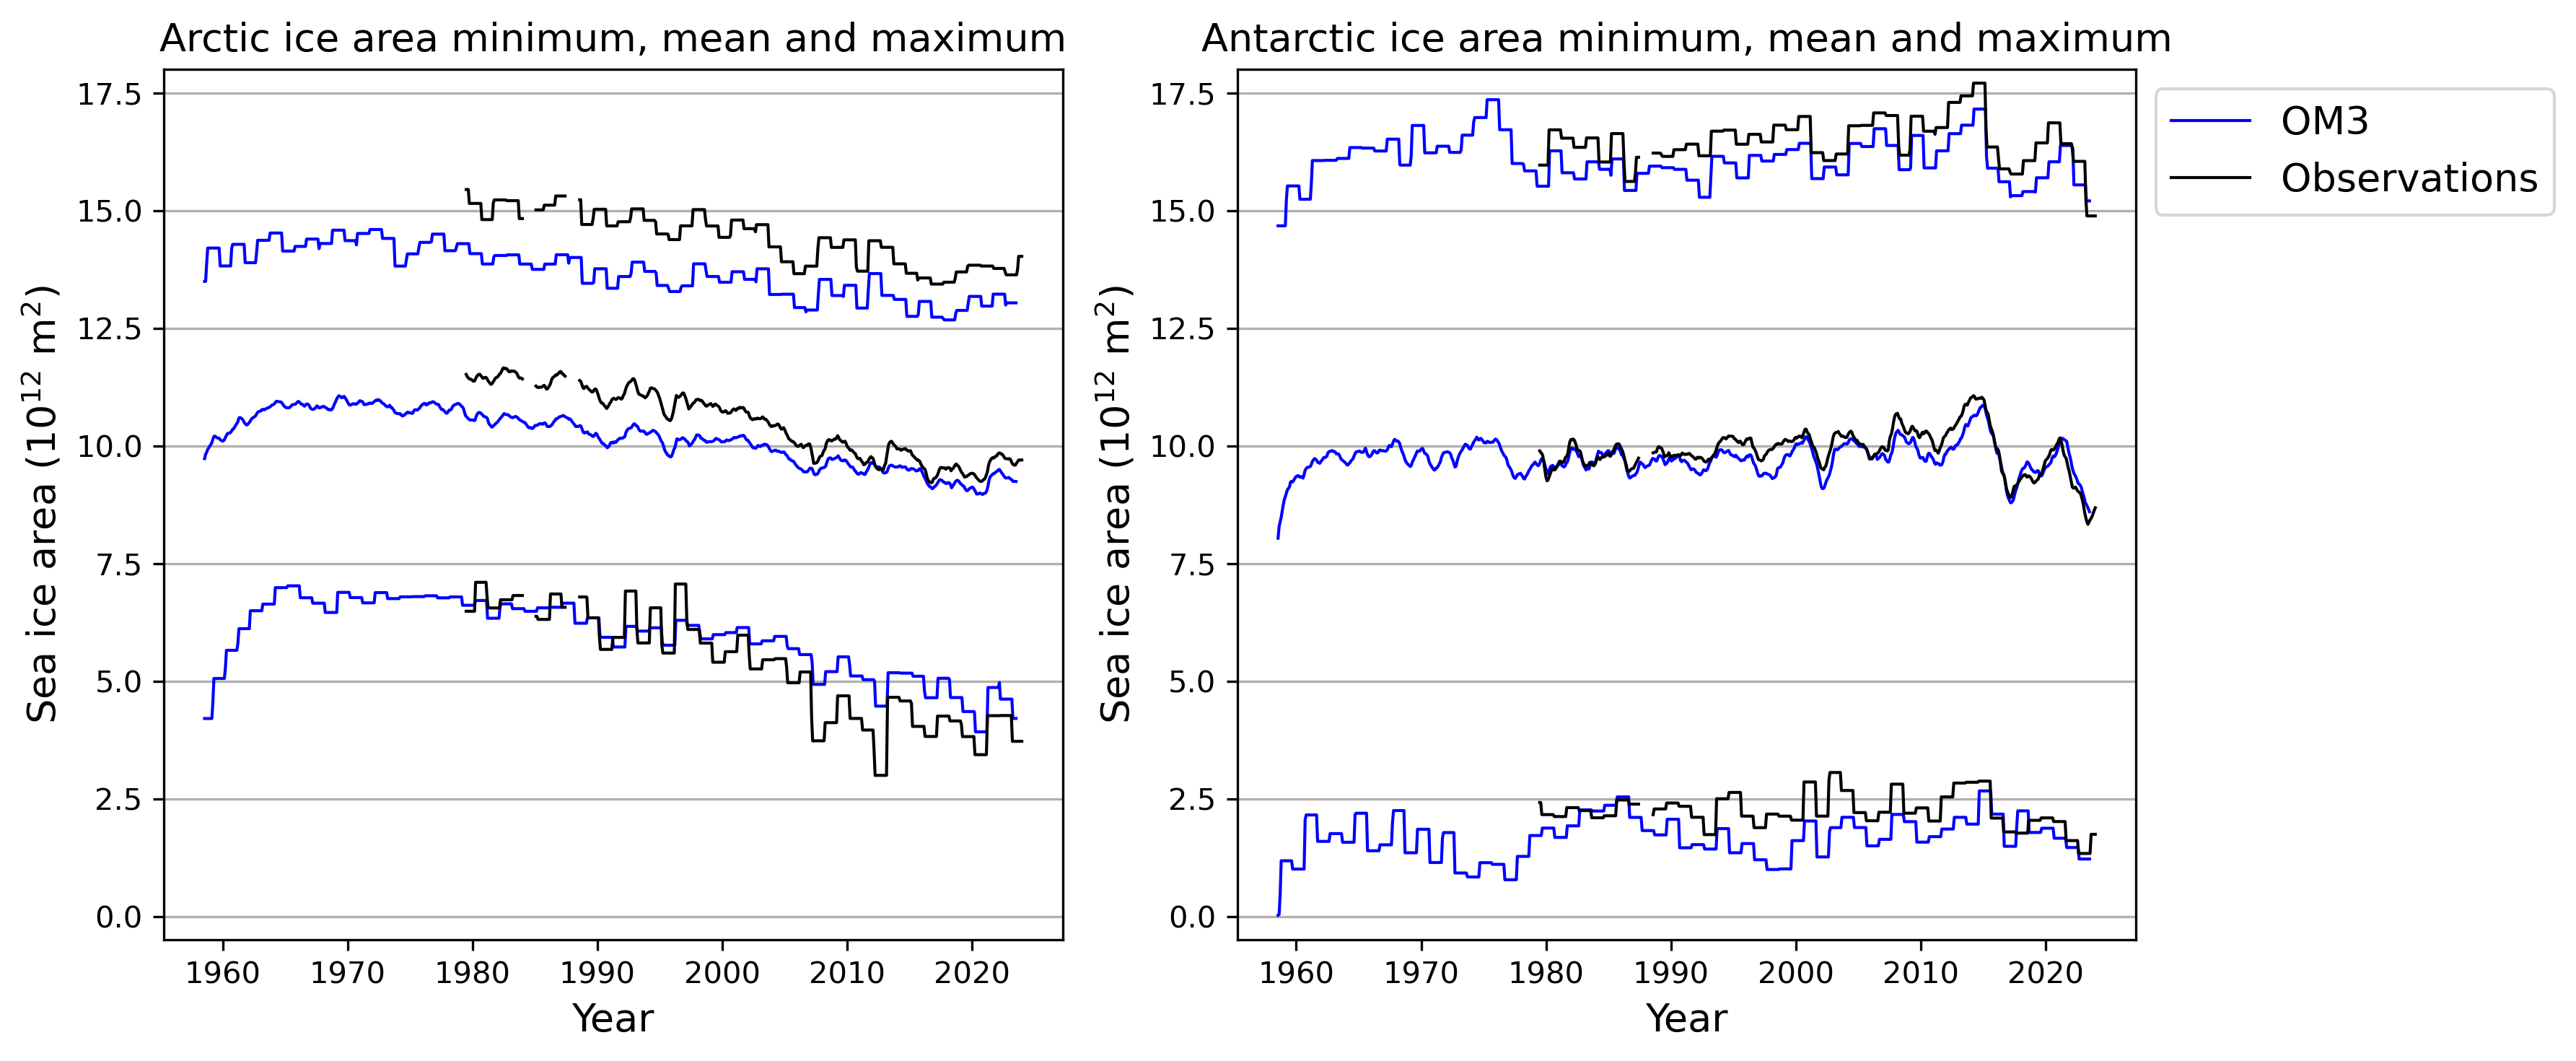

In [94]:
# 12-mo running mean minimum, mean and maximum of area for all models
plt.figure(1,(12,5))

plt.subplot(1,2,1)
v = nh_area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='b', linewidth=1, label='OM3')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='b', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='b', linewidth=1)

plt.subplot(1,2,2)
v = sh_area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='b', linewidth=1, label='OM3')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='b', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='b', linewidth=1)

plt.subplot(1,2,1)
v = nh_area_obs/1e6
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = sh_area_obs/1e6
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=-0.5,ymax=18)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic ice area minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=-0.5,ymax=18)
plt.grid(axis='y')
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic ice area minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# savefigure('ice_area_min_mean_max_all')
plt.show()